## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp002'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    backbone = 'se_resnext50_32x4d'

    in_chans = 65 # 6
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    idxs = range(65)
    # mid = 65 // 2
    # start = mid - CFG.in_chans // 2
    # end = mid + CFG.in_chans // 2
    # idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([65, 224, 224])

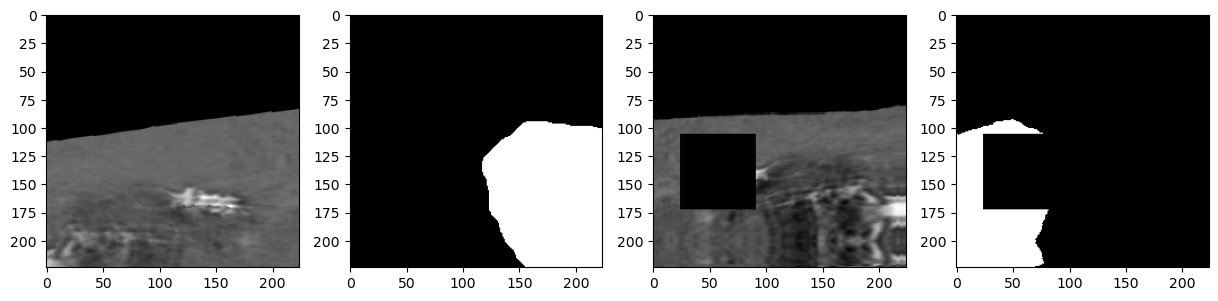

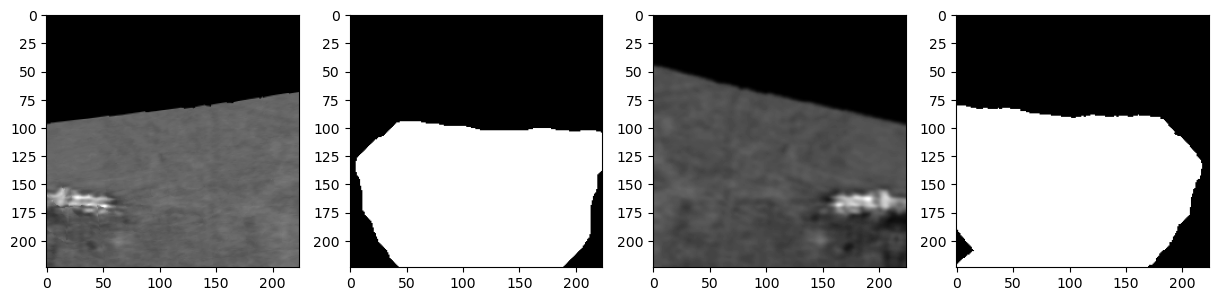

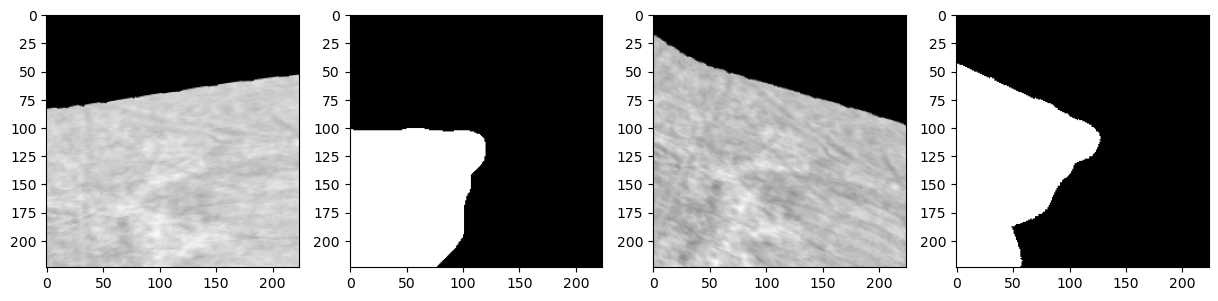

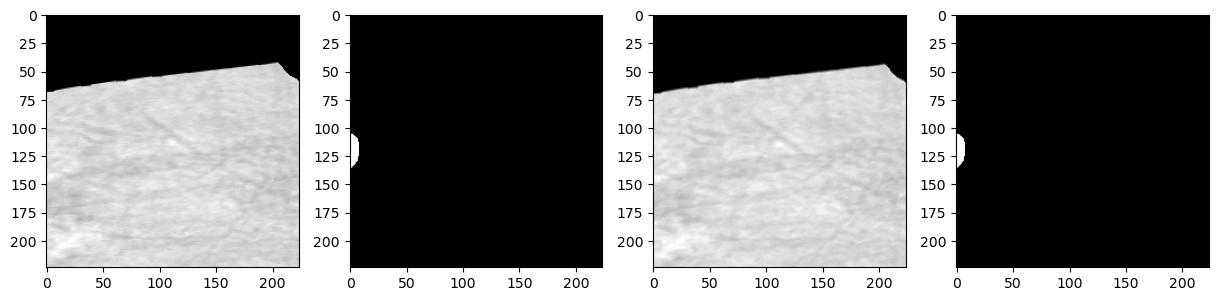

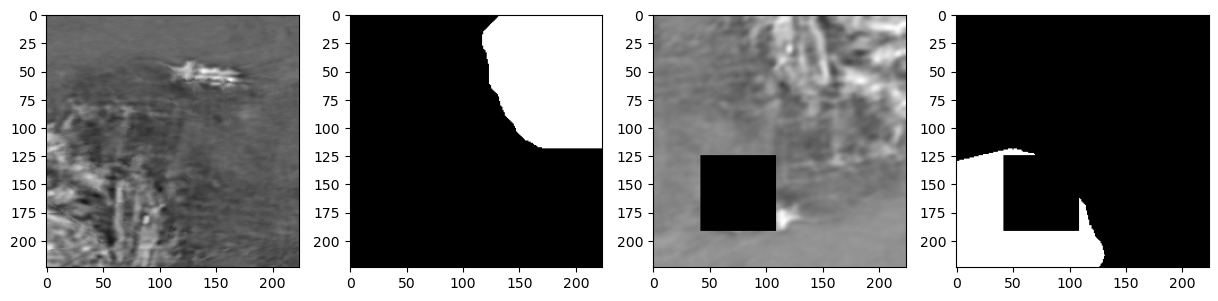

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48120

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09501729527783488
th: 0.15, fbeta: 0.0950438870642283
th: 0.2, fbeta: 0.14252565629666283
th: 0.25, fbeta: 0.15447249822823053
th: 0.3, fbeta: 0.16041311223702806
th: 0.35, fbeta: 0.08184706161891793
th: 0.4, fbeta: 0.003630246381609039
th: 0.45, fbeta: 0.00012021395742615494


best_th: 0.3, fbeta: 0.16041311223702806
Epoch 1 - avg_train_loss: 0.5242  avg_val_loss: 0.3697  time: 271s
Epoch 1 - avgScore: 0.1604
Epoch 1 - Save Best Score: 0.1604 Model
Epoch 1 - Save Best Loss: 0.3697 Model


th: 0.5, fbeta: 1.1658502177207438e-05


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.0955973961207405
th: 0.15, fbeta: 0.15530506829462837
th: 0.2, fbeta: 0.16336551965623564
th: 0.25, fbeta: 0.15033911024352015
th: 0.3, fbeta: 0.014592094751759275
th: 0.35, fbeta: 0.0001708995139452402
th: 0.4, fbeta: 3.1225623527838064e-06


best_th: 0.2, fbeta: 0.16336551965623564
Epoch 2 - avg_train_loss: 0.3742  avg_val_loss: 0.3020  time: 274s
Epoch 2 - avgScore: 0.1634
Epoch 2 - Save Best Score: 0.1634 Model
Epoch 2 - Save Best Loss: 0.3020 Model


th: 0.45, fbeta: 0.0
th: 0.5, fbeta: 0.0


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.16398734720275251
th: 0.15, fbeta: 0.2147597789300498
th: 0.2, fbeta: 0.23433296785075533
th: 0.25, fbeta: 0.221212292752626
th: 0.3, fbeta: 0.16460180101320734
th: 0.35, fbeta: 0.00351619406977691
th: 0.4, fbeta: 0.0
th: 0.45, fbeta: 0.0


best_th: 0.2, fbeta: 0.23433296785075533
Epoch 3 - avg_train_loss: 0.2964  avg_val_loss: 0.2345  time: 275s
Epoch 3 - avgScore: 0.2343
Epoch 3 - Save Best Score: 0.2343 Model
Epoch 3 - Save Best Loss: 0.2345 Model


th: 0.5, fbeta: 0.0


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.186625406410547
th: 0.15, fbeta: 0.21520547525681102
th: 0.2, fbeta: 0.2536282059030562
th: 0.25, fbeta: 0.2737043618386639
th: 0.3, fbeta: 0.28997006478608006
th: 0.35, fbeta: 0.30119576236756146
th: 0.4, fbeta: 0.29067857973305805


best_th: 0.35, fbeta: 0.30119576236756146
Epoch 4 - avg_train_loss: 0.2751  avg_val_loss: 0.2318  time: 274s
Epoch 4 - avgScore: 0.3012
Epoch 4 - Save Best Score: 0.3012 Model
Epoch 4 - Save Best Loss: 0.2318 Model


th: 0.45, fbeta: 0.2063074431918318
th: 0.5, fbeta: 0.0


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24681208789006504
th: 0.15, fbeta: 0.2755931410973619
th: 0.2, fbeta: 0.3007300454721987
th: 0.25, fbeta: 0.3299408905620378
th: 0.3, fbeta: 0.35989595732466434
th: 0.35, fbeta: 0.36937038502195324
th: 0.4, fbeta: 0.3523766733364105
th: 0.45, fbeta: 0.284285301092502


best_th: 0.35, fbeta: 0.36937038502195324
Epoch 5 - avg_train_loss: 0.2649  avg_val_loss: 0.2195  time: 275s
Epoch 5 - avgScore: 0.3694
Epoch 5 - Save Best Score: 0.3694 Model
Epoch 5 - Save Best Loss: 0.2195 Model


th: 0.5, fbeta: 0.16615612492015588


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2106439482139254
th: 0.15, fbeta: 0.27208185480136643
th: 0.2, fbeta: 0.3171565163909223
th: 0.25, fbeta: 0.3472103759832441
th: 0.3, fbeta: 0.3679731166272748
th: 0.35, fbeta: 0.379199887605352
th: 0.4, fbeta: 0.38475638788036587
th: 0.45, fbeta: 0.38444442823503094


best_th: 0.4, fbeta: 0.38475638788036587
Epoch 6 - avg_train_loss: 0.2584  avg_val_loss: 0.2188  time: 274s
Epoch 6 - avgScore: 0.3848
Epoch 6 - Save Best Score: 0.3848 Model
Epoch 6 - Save Best Loss: 0.2188 Model


th: 0.5, fbeta: 0.3805746090978363


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2598364501239025
th: 0.15, fbeta: 0.308803028429415
th: 0.2, fbeta: 0.34020401922820775
th: 0.25, fbeta: 0.36427601275264715
th: 0.3, fbeta: 0.3751403439853248
th: 0.35, fbeta: 0.39029112312295033
th: 0.4, fbeta: 0.3871753447110095
th: 0.45, fbeta: 0.37222837717622226


best_th: 0.35, fbeta: 0.39029112312295033
Epoch 7 - avg_train_loss: 0.2505  avg_val_loss: 0.2156  time: 274s
Epoch 7 - avgScore: 0.3903
Epoch 7 - Save Best Score: 0.3903 Model
Epoch 7 - Save Best Loss: 0.2156 Model


th: 0.5, fbeta: 0.3415994151391875


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2753199398709871
th: 0.15, fbeta: 0.33662931783300726
th: 0.2, fbeta: 0.3851125941901197
th: 0.25, fbeta: 0.41711392623298116
th: 0.3, fbeta: 0.43250450596775025
th: 0.35, fbeta: 0.4315578783471917
th: 0.4, fbeta: 0.4189387348174227
th: 0.45, fbeta: 0.39195510738527095


best_th: 0.3, fbeta: 0.43250450596775025
Epoch 8 - avg_train_loss: 0.2437  avg_val_loss: 0.2106  time: 276s
Epoch 8 - avgScore: 0.4325
Epoch 8 - Save Best Score: 0.4325 Model
Epoch 8 - Save Best Loss: 0.2106 Model


th: 0.5, fbeta: 0.35299987640491504


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29153098766391955
th: 0.15, fbeta: 0.34359436929410014
th: 0.2, fbeta: 0.382494631972032
th: 0.25, fbeta: 0.4178025015269619
th: 0.3, fbeta: 0.44289530757748397
th: 0.35, fbeta: 0.46161534652060277
th: 0.4, fbeta: 0.47014227843990936
th: 0.45, fbeta: 0.4635422843957111


best_th: 0.4, fbeta: 0.47014227843990936
Epoch 9 - avg_train_loss: 0.2348  avg_val_loss: 0.2051  time: 275s
Epoch 9 - avgScore: 0.4701
Epoch 9 - Save Best Score: 0.4701 Model
Epoch 9 - Save Best Loss: 0.2051 Model


th: 0.5, fbeta: 0.4483232071555956


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33944424900062875
th: 0.15, fbeta: 0.39344259466458925
th: 0.2, fbeta: 0.4242583111013768
th: 0.25, fbeta: 0.43760285818716177
th: 0.3, fbeta: 0.4382753808950911
th: 0.35, fbeta: 0.43020817101787306
th: 0.4, fbeta: 0.4098460111708045


best_th: 0.3, fbeta: 0.4382753808950911
Epoch 10 - avg_train_loss: 0.2269  avg_val_loss: 0.2158  time: 274s
Epoch 10 - avgScore: 0.4383


th: 0.45, fbeta: 0.3719193906993365
th: 0.5, fbeta: 0.3308947834917457


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31197826878439516
th: 0.15, fbeta: 0.37282450601881545
th: 0.2, fbeta: 0.42435614203730165
th: 0.25, fbeta: 0.45299330334955673
th: 0.3, fbeta: 0.4627985564249723
th: 0.35, fbeta: 0.45769534363002895
th: 0.4, fbeta: 0.4339260099479644
th: 0.45, fbeta: 0.40534939933508807


best_th: 0.3, fbeta: 0.4627985564249723
Epoch 11 - avg_train_loss: 0.2161  avg_val_loss: 0.2211  time: 274s
Epoch 11 - avgScore: 0.4628


th: 0.5, fbeta: 0.3641246650405357


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3402294344418661
th: 0.15, fbeta: 0.4015994850030227
th: 0.2, fbeta: 0.4478757391091521
th: 0.25, fbeta: 0.47368272937775774
th: 0.3, fbeta: 0.4779847713854778
th: 0.35, fbeta: 0.47070972964808694
th: 0.4, fbeta: 0.4522595594040163
th: 0.45, fbeta: 0.4231259959432361


best_th: 0.3, fbeta: 0.4779847713854778
Epoch 12 - avg_train_loss: 0.2087  avg_val_loss: 0.2180  time: 273s
Epoch 12 - avgScore: 0.4780
Epoch 12 - Save Best Score: 0.4780 Model
Epoch 12 - Save Best Loss: 0.2180 Model


th: 0.5, fbeta: 0.3921145807410896


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3195558742342744
th: 0.15, fbeta: 0.3837422133498272
th: 0.2, fbeta: 0.43244113892492
th: 0.25, fbeta: 0.46417239055519655
th: 0.3, fbeta: 0.48084176870125345
th: 0.35, fbeta: 0.48628271651832483
th: 0.4, fbeta: 0.4747160098990778
th: 0.45, fbeta: 0.45472338677553287


best_th: 0.35, fbeta: 0.48628271651832483
Epoch 13 - avg_train_loss: 0.2007  avg_val_loss: 0.2244  time: 274s
Epoch 13 - avgScore: 0.4863
Epoch 13 - Save Best Score: 0.4863 Model
Epoch 13 - Save Best Loss: 0.2244 Model


th: 0.5, fbeta: 0.42894832588674864


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3127963466961169
th: 0.15, fbeta: 0.35513942454509523
th: 0.2, fbeta: 0.39946222203170884
th: 0.25, fbeta: 0.4317951828683112
th: 0.3, fbeta: 0.4546905452886949
th: 0.35, fbeta: 0.4730978568661427
th: 0.4, fbeta: 0.4860547909735119


best_th: 0.45, fbeta: 0.4862180360262982
Epoch 14 - avg_train_loss: 0.1927  avg_val_loss: 0.2235  time: 274s
Epoch 14 - avgScore: 0.4862


th: 0.45, fbeta: 0.4862180360262982
th: 0.5, fbeta: 0.4745321308956191


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3222357932428597
th: 0.15, fbeta: 0.37001136591965283
th: 0.2, fbeta: 0.40871186182151836
th: 0.25, fbeta: 0.4350826224471742
th: 0.3, fbeta: 0.4542580328481381
th: 0.35, fbeta: 0.47015487139751805
th: 0.4, fbeta: 0.47915435765024905
th: 0.45, fbeta: 0.48102626111738844


best_th: 0.45, fbeta: 0.48102626111738844
Epoch 15 - avg_train_loss: 0.1869  avg_val_loss: 0.2237  time: 274s
Epoch 15 - avgScore: 0.4810


th: 0.5, fbeta: 0.4668473325208067


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3195558742342744
th: 0.15, fbeta: 0.3837422133498272
th: 0.2, fbeta: 0.43244113892492
th: 0.25, fbeta: 0.46417239055519655
th: 0.3, fbeta: 0.48084176870125345
th: 0.35, fbeta: 0.48628271651832483
th: 0.4, fbeta: 0.4747160098990778
th: 0.45, fbeta: 0.45472338677553287


best_th: 0.35, fbeta: 0.48628271651832483


th: 0.5, fbeta: 0.42894832588674864


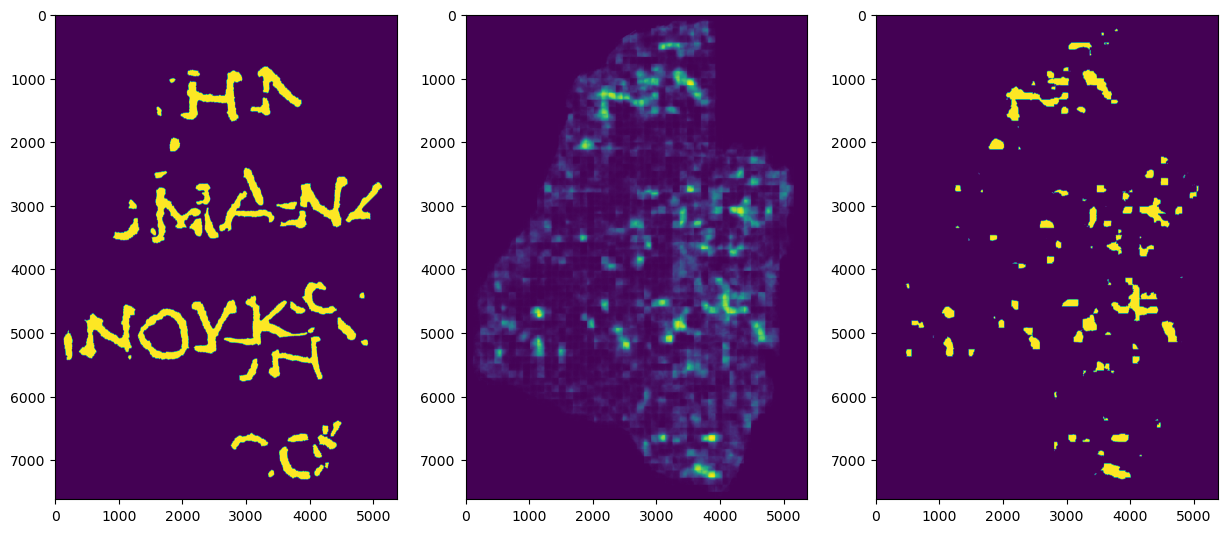

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([2.9311164e+07, 4.7799110e+06, 2.3321200e+06, 1.3246990e+06,
        8.0183100e+05, 5.3439200e+05, 3.8427500e+05, 2.8511800e+05,
        2.1414400e+05, 1.7331000e+05, 1.6108000e+05, 1.3391000e+05,
        1.2314900e+05, 1.1375300e+05, 9.1573000e+04, 6.2739000e+04,
        5.2904000e+04, 3.7751000e+04, 1.6371000e+04, 9.4220000e+03]),
 array([8.14583291e-07, 4.83980951e-02, 9.67953756e-02, 1.45192656e-01,
        1.93589937e-01, 2.41987217e-01, 2.90384498e-01, 3.38781778e-01,
        3.87179059e-01, 4.35576339e-01, 4.83973620e-01, 5.32370900e-01,
        5.80768181e-01, 6.29165461e-01, 6.77562742e-01, 7.25960022e-01,
        7.74357303e-01, 8.22754584e-01, 8.71151864e-01, 9.19549145e-01,
        9.67946425e-01]),
 <BarContainer object of 20 artists>)

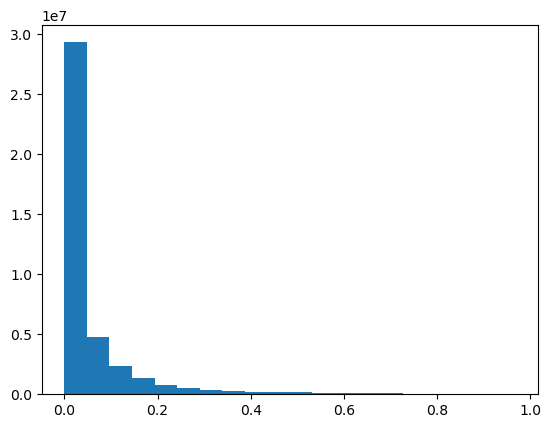

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000